In [16]:
import os
#import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import sys; sys.path.append("/shome/nchernya/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt


In [17]:
clf_trainings = []
plot_classifier_all = []
fpr_dipho_all,tpr_dipho_all = [],[]
fpr_gJets_all,tpr_gJets_all = [],[]
labels=[]

In [18]:
dirs=['deepCSV_01_10_2018','ntuples_2017data_20181023']
for year in (0,1):
    ntuples = dirs[year]
    # "%" sign allows to interpret the rest as a system command
    %env data=$utils.IO.ldata$ntuples
    files = ! ls $data | sort -t_ -k 3 -n
    if (year==0) : signal = [s for s in files if "SM_plus_reweighted_nodes_" in s ]
    else : signal = [s for s in files if "SM_plus_nodes_" in s ]
    diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]
    #diphotonJets_1B = [s for s in files if "DiPhotonJetsBox1B" in s] # will use for limits
    #diphotonJets_2B = [s for s in files if "DiPhotonJetsBox2B" in s] # will use for limits
    gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
    gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

    utils.IO.add_signal(ntuples,signal,1,'nodesCombined',year)
    utils.IO.add_background(ntuples,diphotonJets,-1,'tagsDumper/trees/'+diphotonJets[0][diphotonJets[0].find('output_')+7:diphotonJets[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)
    utils.IO.add_background(ntuples,gJets_lowPt,-2,'tagsDumper/trees/'+gJets_lowPt[0][gJets_lowPt[0].find('output_')+7:gJets_lowPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                            
    utils.IO.add_background(ntuples,gJets_highPt,-2,'tagsDumper/trees/'+gJets_highPt[0][gJets_highPt[0].find('output_')+7:gJets_highPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                           

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018
env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017data_20181023
using background file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.3: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017data_20181023/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.4: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017data_20181023/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root
using background file n.5: /shom

## Folder name where to store output for a specific training

In [19]:
outstr = "28_10_2018_common2017"
labels.append(outstr)
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/28_10_2018_common2017/ doesn't exist, creating it...


In [20]:
from ROOT import TLorentzVector

#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
########################new code branches############################
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
branch_names = 'leadingJet_DeepCSV,subleadingJet_DeepCSV,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826)'.split(",")
branch_cuts = 'leadingJet_pt,subleadingJet_pt,leadingJet_bRegNNCorr,subleadingJet_bRegNNCorr,noexpand:(leadingJet_pt/leadingJet_bRegNNCorr),noexpand:(subleadingJet_pt/subleadingJet_bRegNNCorr)'.split(',')
#cuts = 'leadingJet_pt>20 & subleadingJet_pt> 20 & (leadingJet_pt/leadingJet_bRegNNCorr>20) & (subleadingJet_pt/subleadingJet_bRegNNCorr>20) '
cuts = 'leadingJet_pt>0'
######################

#event_branches = ['event','sigmaMOverM','noexpand:(dijetSigmaMOverM*1.4826)']
event_branches = ['event','weight','MX']

branch_names = branch_names + ['rho']
branch_names = branch_names+b_reg_branches
resolution_weighting = 'ggbb' # None, gg or ggbb


branch_names = [c.strip() for c in branch_names]
print branch_names

event_bkg,event_sig = None,None
preprocessing.set_signals_and_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)


X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.set_variables(branch_names+['year'],use_event_num=True)

print 'total background shape : ',y_bkg.shape
print 'total signal shape : ',y_sig.shape

    
##relative weighting between components of one class is kept, all classes normalized to the same
if 'gg' in resolution_weighting : 
    print 'weighting Signal with gg resolution '
    weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)

    if 'bb' in resolution_weighting : 
        print 'weighting Signal with bb resolution '
        weights_sig=preprocessing.weight_signal_with_resolution_bjet(weights_sig,y_sig)  
##reweight also resonant higgs with resolution
##weights_bkg=preprocessing.weight_background_with_resolution(weights_bkg,y_bkg,-3)
##weights_bkg=preprocessing.weight_background_with_resolution(weights_bkg,y_bkg,-4)



info_file = open(utils.IO.plotFolder+"info_%s.txt"%outstr,"w") 
info_file.write("\n".join(branch_names))
info_file.write("Resolution weighting : %s\n"%resolution_weighting)
info_file.write("Cuts : %s\n"%cuts)
info_file.close()

weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

X_bkg,y_bkg,weights_bkg,event_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg,event_num = np.asarray(event_bkg))
X_sig,y_sig,weights_sig,event_sig = preprocessing.randomize(X_sig,y_sig,weights_sig,event_num = np.asarray(event_sig))


#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig,event_num_bkg = event_bkg, event_num_sig = event_sig)


#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig,event_bkg.reshape(-1,))

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig,event_bkg.reshape(-1,))

w_total_train = preprocessing.get_total_training_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()


['leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'PhoJetMinDr', 'rho', 'noexpand:(leadingJet_bRegNNResolution*1.4826)', 'noexpand:(subleadingJet_bRegNNResolution*1.4826)', 'noexpand:(sigmaMJets*1.4826)']
using tree:nodesCombined
using tree:nodesCombined
Weighting with lumi : 


/shome/nchernya/HHbbgg_ETH_devel/Training/python/preprocessing_utils.py:63: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  m0, bins = np.histogram(df0['MX'],bins=np.linspace(200.,2000.,101),weights=df0["weight"],normed=True)
/shome/nchernya/HHbbgg_ETH_devel/Training/python/preprocessing_utils.py:64: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  m1, _ = np.histogram(df1['MX'],bins=bins,weigh

using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
Weighting with lumi : 
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCP5_13TeV_Pythia8_13TeV_DoubleHTag_0
Weighting with lumi : 
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCP5_13TeV_Pythia8_13TeV_DoubleHTag_0
Weighting with lumi : 
total background shape :  (1853356, 1)
total signal shape :  (1861557, 1)
weighting Signal with gg resolution 
weighting Signal with bb resolution 
4012.2974245895034


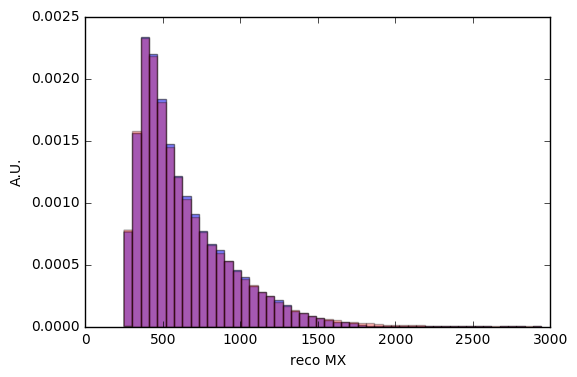

In [21]:
MX_2016 = np.array(utils.IO.signal_df[0]['MX'])
weight_2016 = np.array(utils.IO.signal_df[0]['weight'])

MX_2017 = np.array(utils.IO.signal_df[1]['MX'])
weight_2017 = np.array(utils.IO.signal_df[1]['weight'])


n, bins, patches = plt.hist(MX_2016, 50, facecolor='b', alpha=0.5,weights=weight_2016,normed=True,label='2016')
plt.xlabel('reco MX')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(MX_2017, bins=bins,facecolor='r', alpha=0.3,weights=weight_2017,normed=True,label='2017')
plt.show()
plt.savefig(utils.IO.plotFolder+"mixMX_2016_2017"+"_"+str(outstr)+".pdf")
plt.show()

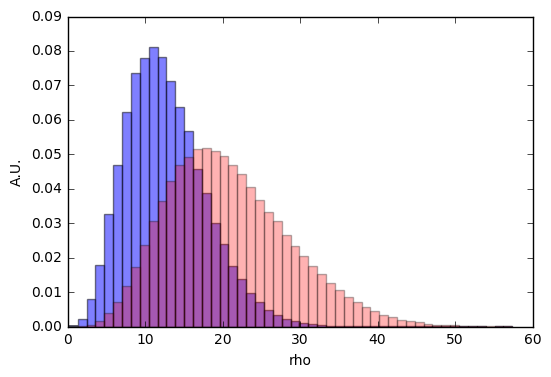

In [24]:
MX_2016 = np.array(utils.IO.signal_df[0]['rho'])
weight_2016 = np.array(utils.IO.signal_df[0]['weight'])

MX_2017 = np.array(utils.IO.signal_df[1]['rho'])
weight_2017 = np.array(utils.IO.signal_df[1]['weight'])


n, bins, patches = plt.hist(MX_2016, 50, facecolor='b', alpha=0.5,weights=weight_2016,normed=True,label='2016')
plt.xlabel('rho')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(MX_2017, bins=bins,facecolor='r', alpha=0.3,weights=weight_2017,normed=True,label='2017')
plt.show()
plt.savefig(utils.IO.plotFolder+"rho_2016_2017"+"_"+str(outstr)+".pdf")
plt.show()

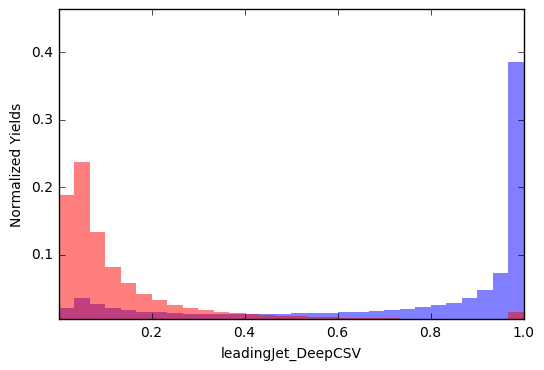

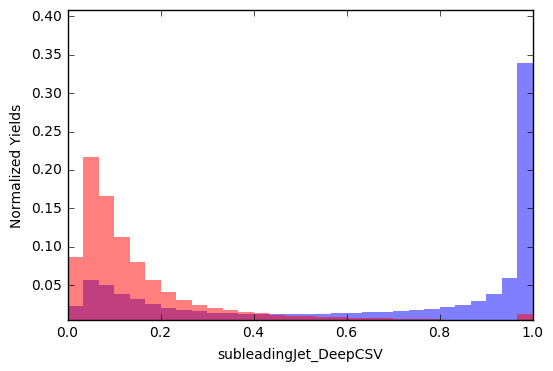

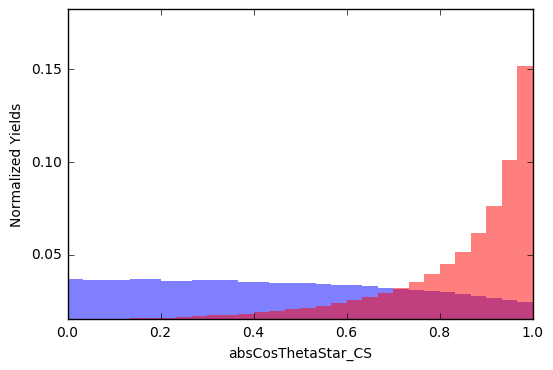

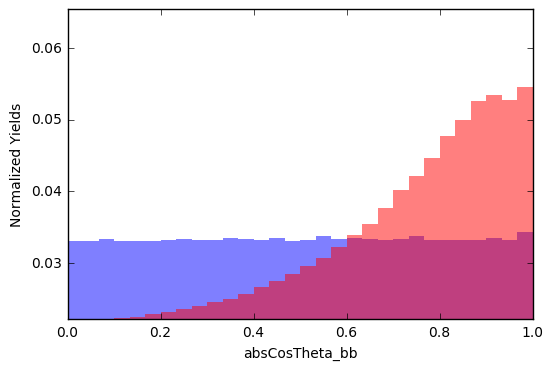

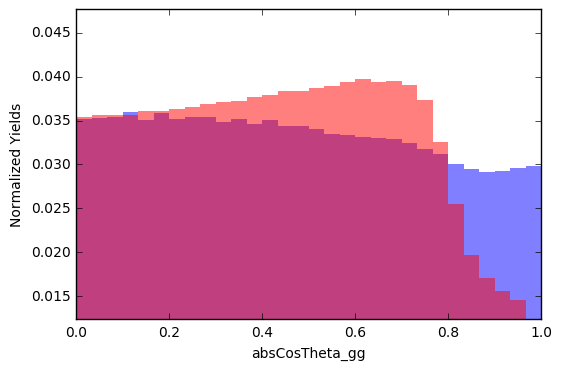

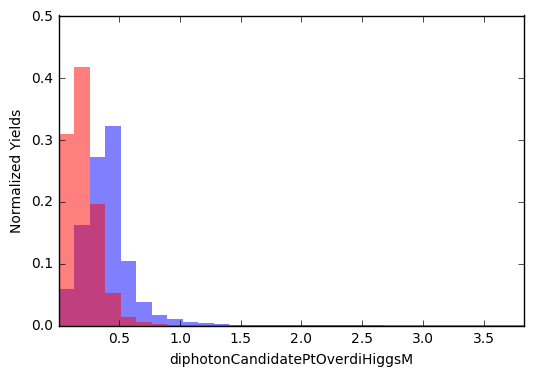

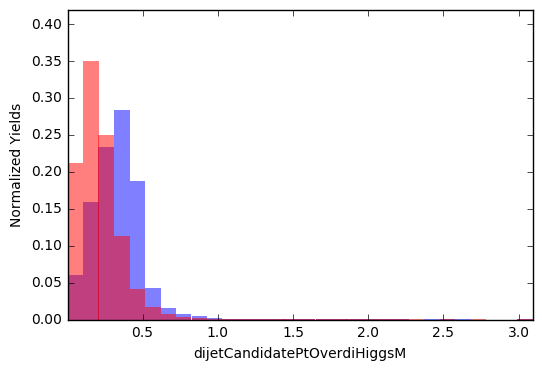

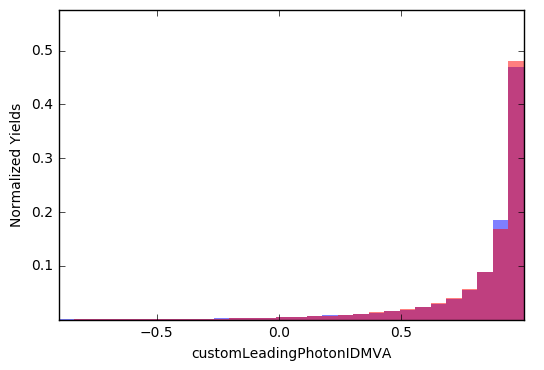

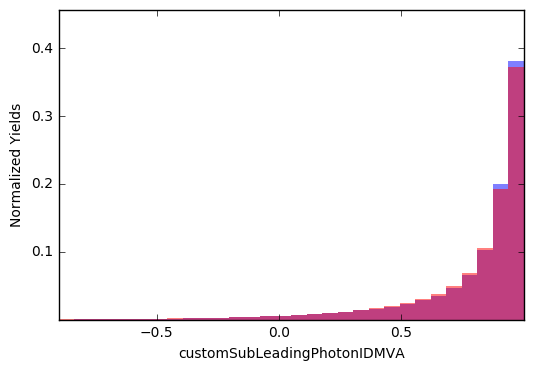

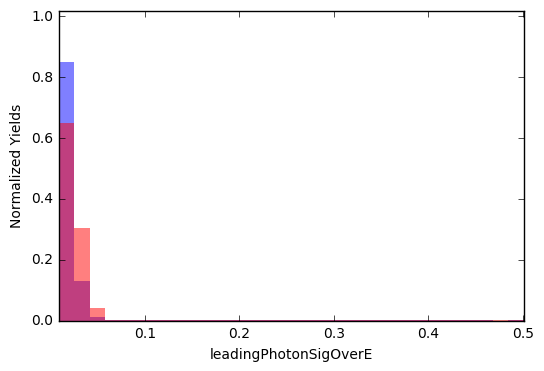

KeyboardInterrupt: 

In [38]:
plotting.plot_input_variables(X_sig,X_bkg,branch_names+branch_cuts+['year'],None,30,'')
#utils.IO.signal_df[0]['(subleadingJet_pt/subleadingJet_bRegNNCorr)'].plot.hist(bins=100,range=[0,50])
#plt.show()

In [25]:
from sklearn.externals import joblib
import xgboost as xgb

In [26]:
########final optimization with all fixed#######
#optimized parameters

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=1e-05, missing=None,
       n_estimators=1000, n_jobs=1, nthread=20, objective='binary:logistic',
       random_state=0, reg_alpha=0.0, reg_lambda=0.1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

#the smallest classifier from optimized grid
grid={'reg_alpha': 0.0, 'learning_rate': 0.2, 'min_child_weight': 0.0001, 'n_estimators': 1000, 'reg_lambda': 0.05, 'max_depth': 3, 'gamma': 0}
clf.set_params(**grid)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_%s.pkl'%outstr), compress=9)
clf_trainings.append(clf)

IOError: [Errno 2] No such file or directory: '/t3home/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_28_10_2018_common2017.pkl'

In [27]:
## When the training was already done
#clf =joblib.load(os.path.expanduser('~/HHbbgg_ETH_devel/Training/output_files/training_with_24_10_2018_common2017.pkl')) 
#clf_trainings.append(clf)

In [28]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=0.0001, missing=None,
       n_estimators=1000, n_jobs=1, nthread=20, objective='multi:softprob',
       random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

['working_short_train_test2.pkl']

[[ 0.32011291  0.32882422  0.3510628 ]]
[[ 0.99346  0.9157   0.97826  0.44868  0.58882  0.0502   0.11265  0.91608
   0.94145  0.01212  0.02833  0.01533  1.45464  0.09147  0.10969  0.07137]]
0.358697433333


0.9789686999999998

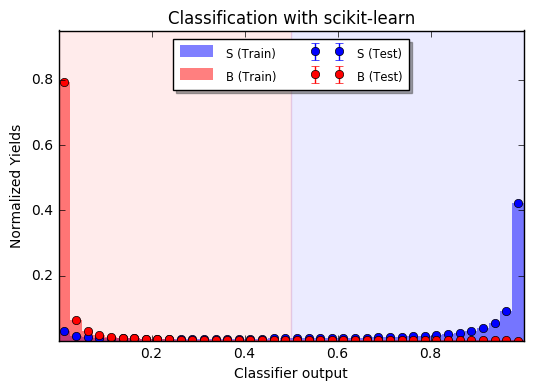

In [29]:
plt.clf()
plot_classifier = plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()

plot_classifier_all.append(plot_classifier)

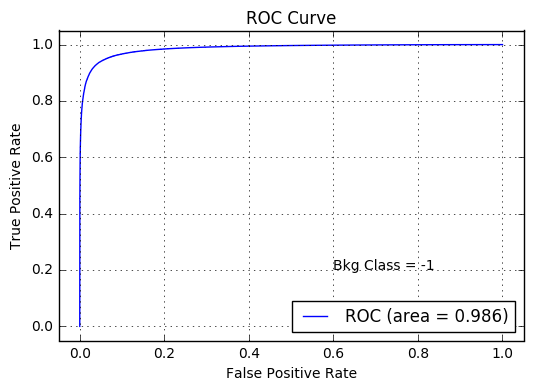

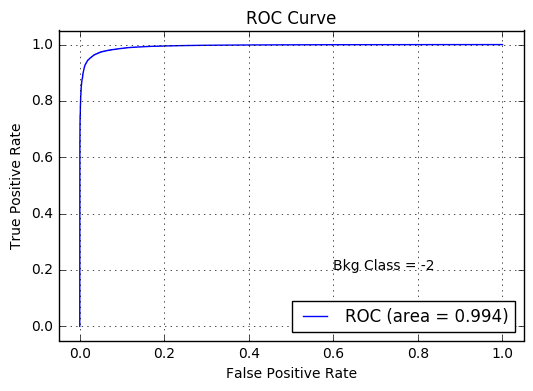

In [30]:
fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()
fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
plt.show()

fpr_dipho_all.append(fpr_dipho)
tpr_dipho_all.append(tpr_dipho)
fpr_gJets_all.append(fpr_gJets)
tpr_gJets_all.append(tpr_gJets)

In [ ]:
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/training_newcodecd /'

In [ ]:
print labels
labels[0][labels[0].find('les')+4:]

In [ ]:
labels_legend = [labels[i][labels[i].find('bles')+4:] for i in range(0,len(labels))]
labels_legend = [labels[i] for i in range(0,len(labels))]

In [ ]:
print labels_legend
print labels

In [ ]:
plt.clf()
for i in range(0,len(labels)):
    plt.plot(fpr_dipho_all[i], tpr_dipho_all[i], lw=1, label=labels_legend[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = diPhotons')
plt.grid()
outString = "comparison_diphotons_resWeighting"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

In [ ]:
for i in range(0,len(labels)):
    plt.plot(fpr_gJets_all[i], tpr_gJets_all[i], lw=1, label=labels_legend[i])


plt.xlim([-0.05, 0.4])
plt.ylim([0.6, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.text(0.1,0.85, 'Bkg Class = gJets')
plt.grid()
outString = "comparison_gJets_resWeighting"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_"+str(outString)+".pdf")
plt.show()

In [ ]:
print y_total_train.shape
print X_total_train.shape

In [ ]:
type(X_bkg)

In [ ]:
print np.asarray(event_sig)
print event_sig

In [ ]:
y_total_train

In [40]:
for i in range(2,2):
    print 'hi'

In [ ]:
X_bkg, event_bkg,weights_bkg

In [ ]:
X_bkg[np.where(event_bkg%2==0),:][0]